C:\Users\Almazt\AppData\Local\Temp\ipykernel_20756\3347278808.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
C:\Users\Almazt\AppData\Local\Temp\ipykernel_20756\3347278808.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TCPul'].fillna(df['TCPul'].mean(), inplace=True)
C:\Users\Almazt\AppData\Local\Temp\ipykernel_20756

              MSISDN          TCPul      RTTul  Throughputul  \
0       3.360100e+10  759658.664811   0.000000          39.0   
1       3.360100e+10  759658.664811   1.000000          51.0   
2       3.360100e+10  759658.664811  17.662883          49.0   
3       3.360101e+10  759658.664811  15.000000          44.0   
4       3.360101e+10  390430.332406   2.500000        8224.5   
...              ...            ...        ...           ...   
106851  3.379000e+10    3001.000000  10.000000         387.0   
106852  3.379000e+10  759658.664811   6.000000          48.0   
106853  3.197021e+12  759658.664811  17.662883           0.0   
106854  3.370000e+14  759658.664811  17.662883          22.0   
106855  8.823971e+14  759658.664811  17.662883           0.0   

                             HandsetType  
0         Huawei P20 Lite Huawei Nova 3E  
1                 Apple iPhone 7 (A1778)  
2                              undefined  
3                Apple iPhone 5S (A1457)  
4               

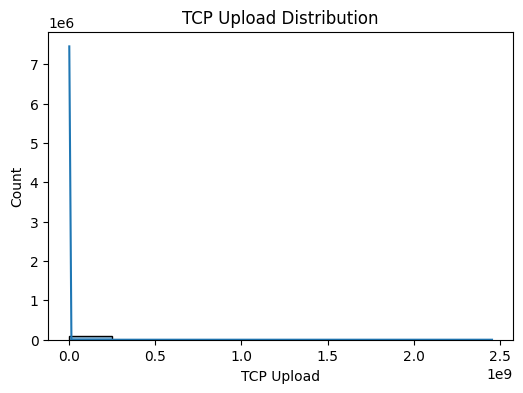

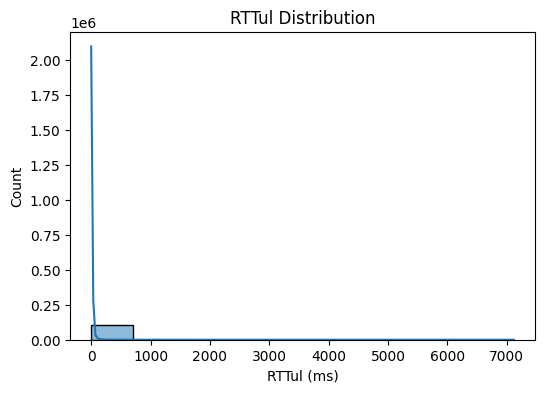

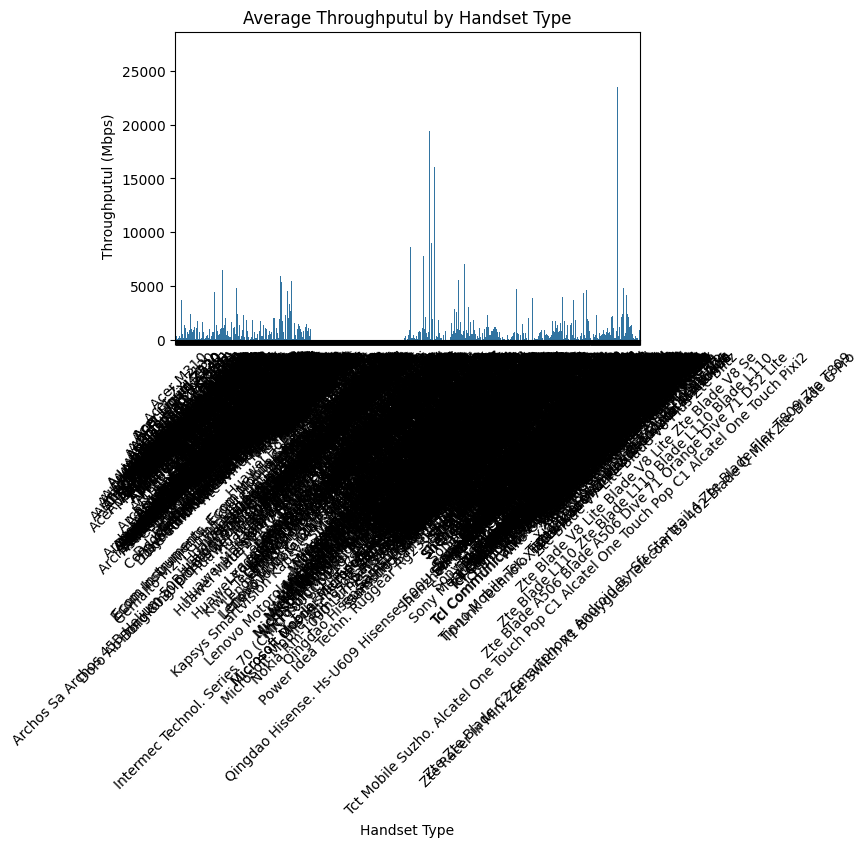

In [1]:
# Step 1: Data Aggregation
# 1.1 Aggregate Metrics Per User
# We need to aggregate TCP retransmissions, RTTul, Throughputul, and handset data per user (MSISDN).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

# Connect to psycopg2 database (or create it if it doesn't exist)
from sqlalchemy import create_engine

connection = psycopg2.connect("dbname=Teleco user=postgres password=Leul@123")

# Create a cursor object to interact with the database
cursor = connection.cursor()

# Query the data
query = "SELECT * FROM xdr_data"

# Load data into a pandas DataFrame
df = pd.read_sql_query(query, connection)
# print(df.columns)

# Treat missing values (replace with mean for numeric columns, mode for categorical)
df['TCPul'].fillna(df['TCPul'].mean(), inplace=True)
df['RTTul'].fillna(df['RTTul'].mean(), inplace=True)
df['Throughputul'].fillna(df['Throughputul'].mean(), inplace=True)
df['HandsetType'].fillna(df['HandsetType'].mode()[0], inplace=True)

# Aggregate per user
user_experience = df.groupby('MSISDN').agg({
    'TCPul': 'mean',
    'RTTul': 'mean',
    'Throughputul': 'mean',
    'HandsetType': 'first'  # Take the first handset if users have multiple
}).reset_index()

# Display aggregated data
print(user_experience)

# 1.2 Top, Bottom, and Most Frequent Values
# Step 2: Identify Top, Bottom, and Frequent Metrics
# 2.1 Top, Bottom, and Most Frequent Values
# Let’s compute the top, bottom, and most frequent values for RTTul, Throughputul, and TCP retransmission.

# Top 10 values for RTTul
top_RTTul = user_experience.nlargest(10, 'RTTul')
bottom_RTTul = user_experience.nsmallest(10, 'RTTul')
frequent_RTTul = user_experience['RTTul'].value_counts().head(10)

# Repeat for Throughputul
top_Throughputul = user_experience.nlargest(10, 'Throughputul')
bottom_Throughputul = user_experience.nsmallest(10, 'Throughputul')
frequent_Throughputul = user_experience['Throughputul'].value_counts().head(10)

# TCP Retransmission
top_tcp = user_experience.nlargest(10, 'TCPul')
bottom_tcp = user_experience.nsmallest(10, 'TCPul')
frequent_tcp = user_experience['TCPul'].value_counts().head(10)

# Display results
print("Top RTTul Values:\n", top_RTTul)
print("Frequent Throughputul Values:\n", frequent_Throughputul)

# Step 3: Clustering & Segmentation
# 3.1 Normalize Data for Clustering
# Normalize RTTul, Throughputul, and TCP retransmission for clustering.

from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = user_experience[['TCPul', 'RTTul', 'Throughputul']]

# Normalize data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)

# Preview normalized data
print(normalized_df.head())

# 3.2 Perform K-means Clustering
# Run K-means clustering to group users into three clusters.

from sklearn.cluster import KMeans

# Define number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit and predict clusters
user_experience['Experience_Cluster'] = kmeans.fit_predict(normalized_df)

# Display cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

# Display clustered data
print(user_experience[['MSISDN', 'Experience_Cluster']])

# Step 4: Insight Derivation
# 4.1 Analyze TCP Retransmission and RTTul Distribution
# Visualize the distribution of TCP retransmissions and RTTul to understand the user experience.

import matplotlib.pyplot as plt
import seaborn as sns

# TCP retransmission distribution
plt.figure(figsize=(6, 4))
sns.histplot(user_experience['TCPul'], kde=True, bins=10)
plt.title('TCP Upload Distribution')
plt.xlabel('TCP Upload')
plt.show()

# RTTul distribution
plt.figure(figsize=(6, 4))
sns.histplot(user_experience['RTTul'], kde=True, bins=10)
plt.title('RTTul Distribution')
plt.xlabel('RTTul (ms)')
plt.show()

# 4.2 Visualize Throughputul Per Handset
# Aggregate Throughputul by handset and visualize it.

# Aggregate Throughputul by handset type
handset_Throughputul = user_experience.groupby('HandsetType')['Throughputul'].mean().reset_index()

# Plot average Throughputul per handset type
plt.figure(figsize=(6, 4))
sns.barplot(x='HandsetType', y='Throughputul', data=handset_Throughputul)
plt.title('Average Throughputul by Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Throughputul (Mbps)')
plt.xticks(rotation=45)
plt.show()
